In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from sklearn.preprocessing import RobustScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn_extra.cluster  import KMedoids
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [12]:
root_path = 'images'
img_files = os.listdir(root_path)[0:2]
img_files

['1_aki-kuroda_untitled-1995.jpg',
 '2_aleksey-savrasov_little-house-in-the-province-spring-1878.jpg']

In [24]:
def load_images(root_path, file_names, flatten=True, normalize=True, resize=False):
    """
    Retorna una lista con arreglos de números. Cada arreglo representa una imagen RGB.
    
    Parametros:
    root_path : str
        Directorio raíz de las imágenes.
    file_names : list
        Lista con los nombres de los archivos de imágenes.
    flatten : bool, opcional
        Si es True, aplana las imágenes a una lista de píxeles de tres dimensiones.
    normalize : bool, opcional
        Si es True, normaliza los valores de píxeles al rango [0, 1].
    """
    image_list = list()
    for file in file_names:
        img = cv2.imread(os.path.join(root_path, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if resize:
            img = cv2.resize(img, (200, 200))
        if flatten:
            img = img.reshape((-1, 3))
        if normalize:
            img = img / 255.0
        image_list.append(img)
    return image_list

In [26]:
original_images = load_images(root_path, img_files, flatten=False, normalize=False, resize=False)
formatted_images = load_images(root_path, img_files, flatten=True, normalize=True, resize=True)
data_img_0 = pd.DataFrame(data = formatted_images[0], columns=["Red", "Green", "Blue"])
data_img_0.describe()

,Red,Green,Blue
count,40000.000000,40000.000000,40000.000000
mean,0.540493,0.452094,0.397622
std,0.326954,0.296158,0.283081
min,0.023529,0.015686,0.000000
25%,0.215686,0.192157,0.188235
50%,0.635294,0.462745,0.243137
75%,0.870588,0.639216,0.470588
max,1.000000,1.000000,1.000000


No se harán revisiones por duplicados ya que al estar trabajando con imágenes son esperados valores similares para distintos píxeles en la imágen, esto no necesariamente representa un error.

Se revisa la existencia de datos nulos por algún error de carga.

In [27]:
print(f'Nulos:\n{data_img_0.isna().sum()}')

Nulos:
Red      0
Green    0
Blue     0
dtype: int64


No existen nulos para este conjunto de datos, lo cual es esperado ya que estamos tratando el espacio de datos completo de la imágen el cual es homogéneo.

Podemos determinar si hay datos que puedan considerarse extremos, cuántos y en qué variables utlizando el rango intercuartil:

In [28]:
# Se calcula el rango intercuartil y se determinan los outliers por variable
Q1 = data_img_0.quantile(0.25)
Q3 = data_img_0.quantile(0.75)
IQR = Q3 - Q1
outliers = ((data_img_0 < (Q1 - 1.5 * IQR)) | (data_img_0 > (Q3 + 1.5 * IQR)))
total = outliers.sum() 
total

Red         0
Green       0
Blue     5974
dtype: int64

## Estandarización
Finalmente, realizaremos una estandarización de los datos, para así evitar que las magnitudes de las variables tengan influencia sobre los algoritmos. En este caso usaremos un RobustScaler() que es más robusto que StandarScaler() cuando se tienen valores extremos:

In [71]:
robust_scaler = RobustScaler()
scaled_data = robust_scaler.fit_transform(data_img_0)
scaled_df = pd.DataFrame(scaled_data, columns=data_img_0.columns)
scaled_df.describe()

,Red,Green,Blue
count,40000.000000,40000.000000,40000.000000
mean,-0.144756,-0.023824,0.547134
std,0.499242,0.662458,1.002579
min,-0.934132,-1.000000,-0.861111
25%,-0.640719,-0.605263,-0.194444
50%,0.000000,0.000000,0.000000
75%,0.359281,0.394737,0.805556
max,0.556886,1.201754,2.680556


## Agrupación con KMeans y KMedoides

In [30]:
def elbow_plot(X, model, k_min=2, k_max=10):
    """
    Genera la gráfica para el método del codo usando KMeans
    
    Parametros:
    X : np.array
        El arreglo con los datos
    model : str
        "kmeans" o "kmedoids", especifica el modelo a entrenar.
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    inertias = []
    for i in range(k_min, k_max+1):
        if model == "kmeans":
            model_k = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
        else:
            model_k = KMedoids(n_clusters=i, max_iter=300, metric='manhattan', random_state=0)
        # Entrenamos el modelo
        model_k.fit(X)
        # Almacenamos el valor de inercia
        inertias.append(model_k.inertia_)
    
    # Graficamos los valores de inercia
    plt.plot(range(k_min,k_max+1), inertias, marker='o')
    plt.xlabel('Número de clústeres')
    plt.ylabel('Inercia')
    plt.grid()
    plt.show()

Agregaremos la línea display(pd.DataFrame({'K': range(k_min,k_max+1), 'Coeficiente': scores})) para mostrar los valores específicos del coeficiente de la silueta. Esto nos brindará información más específica para la selección del hiperparámetro k:

In [31]:
def silhouette_plot(X, model, k_min=2, k_max=5):
    """
    Genera la gráfica con el coeficiente de la silueta
    
    Parametros:
    X : np.array
        El arreglo con los datos
    model : str
        "kmeans" o "kmedoids", especifica el modelo a entrenar.
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    scores = []
    for i in range(k_min, k_max+1):
        if model == "kmeans":
            model_k = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
        else:
            model_k = KMedoids(n_clusters=i, max_iter=300, random_state=0)
        # Entrenamos el modelo
        model_k.fit(X)
        # Almacenamos el coeficiente de la silueta
        score = silhouette_score(X, model_k.labels_)
        scores.append(score)
    # Mostramos los valores de los coeficientes
    display(pd.DataFrame({'K': range(k_min,k_max+1), 'Coeficiente': scores}))
    # Graficamos los valores del coeficiente de la silueta
    plt.plot(range(k_min,k_max+1), scores, marker='o')
    plt.xlabel('Número de clústeres')
    plt.ylabel('Silhouette Score')
    plt.grid()
    plt.show()

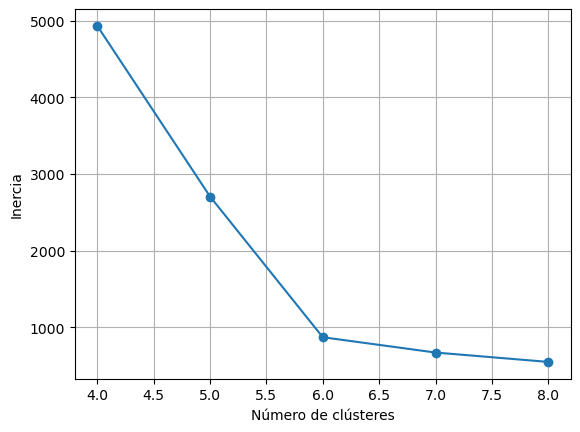

,K,Coeficiente
0,4,0.703601
1,5,0.785952
2,6,0.869903
3,7,0.806407
4,8,0.712719


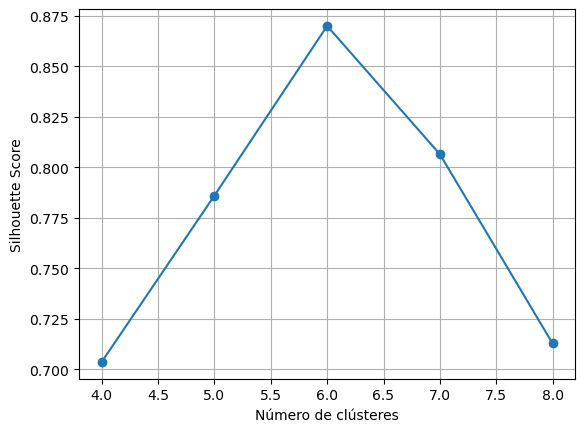

In [32]:
elbow_plot(scaled_df, "kmeans", 4, 8)
silhouette_plot(scaled_df, "kmeans", 4, 8)

C:\Users\AV\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cluster (6).
  warnings.warn(
C:\Users\AV\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cluster (6).
  warnings.warn(


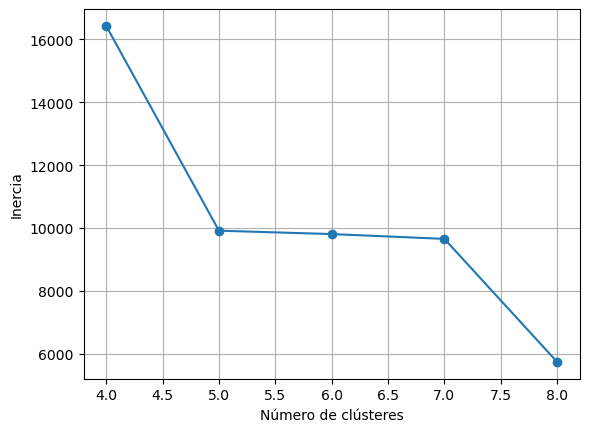

,K,Coeficiente
0,4,0.703562
1,5,0.692026
2,6,0.773492
3,7,0.679698
4,8,0.766710


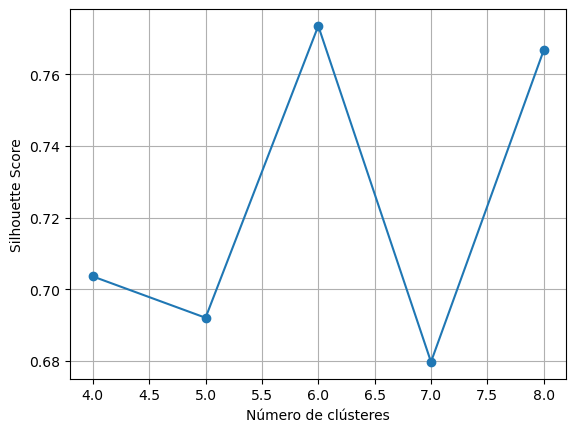

In [33]:
elbow_plot(scaled_df, "kmedoids", 4, 8)
silhouette_plot(scaled_df, "kmedoids", 4, 8)

Con el análisis realizado para los dos algoritmos, sabemos el mejor valor de k, pero podemos utilizar cualquiera de los dos algoritmos para entrenar el mejor modelo. Como en este conjunto de datos todas las variables son numéricas, utilizaremos KMeans con k=6

In [89]:
mejor_modelo = KMeans(n_clusters=6, max_iter=300, n_init=10, random_state=0)

In [45]:
tsne = TSNE(random_state=0, verbose=0, n_jobs=-1)
response = pd.DataFrame(tsne.fit_transform(formatted_images[0]))
response

In [55]:
pca = PCA(n_components = 3)

In [90]:
pipe = Pipeline(steps=[("pca", pca), ("scaler", robust_scaler), ("model", mejor_modelo)])

In [129]:
def printColorBars():
  centroids = mejor_modelo.cluster_centers_
  i_centroids = pca.inverse_transform(robust_scaler.inverse_transform(centroids))
  labels = mejor_modelo.labels_
  indexes, values = np.unique(labels, return_counts=True)
  rects = plt.bar(indexes, values)
  for i, bar in enumerate(rects):
    
    bar.set_color([i_centroids[i][0], i_centroids[i][1], i_centroids[i][2]])
  plt.title("distribución de colores para la imágen ")
  plt.xlabel('Clúster')
  plt.ylabel('Número de datos')
  plt.xticks(indexes)
  i_centroids *= 255

Como análisis inicial, veremos la distribución de nuestros clientes con respecto a los seis grupos:

In [131]:
def printImage(img_idx):
  # Imprimiendo la imagen original
  figsize = len(original_images[img_idx]) * 0.0021
  colors = mejor_modelo.cluster_centers_
  plt.figure(figsize=(15, figsize))

  plt.subplot(1, 4, 1)
  plt.title('Imagen original')
  plt.imshow(original_images[img_idx])
  plt.axis('off')
  
  plt.show()

  print('----')
  print('')

Ejecutando modelo en imágen  1_aki-kuroda_untitled-1995.jpg


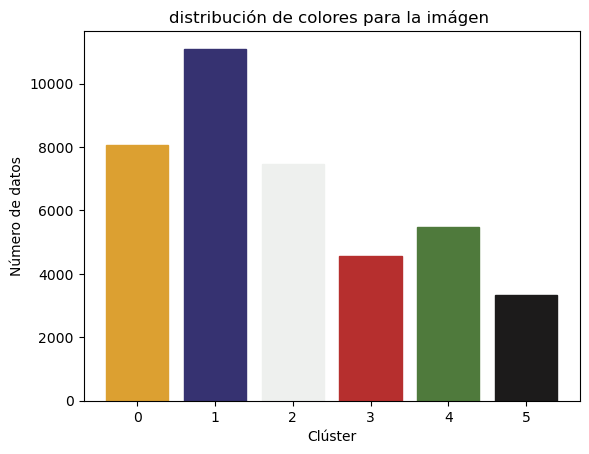

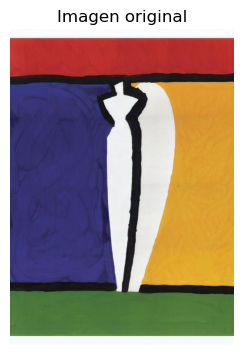

----

Ejecutando modelo en imágen  2_aleksey-savrasov_little-house-in-the-province-spring-1878.jpg


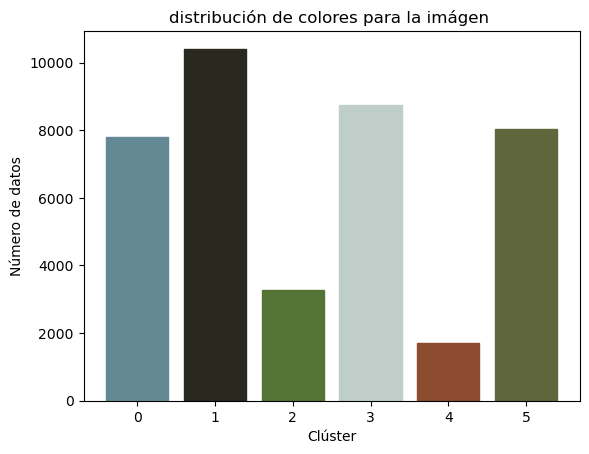

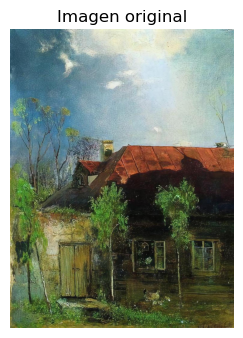

----



In [133]:
for i in range(len(img_files)):
  pipe.fit(formatted_images[i])
  print('Ejecutando modelo en imágen ',img_files[i] )
  printColorBars()
  printImage(i)
